# Part I: Preprocessing

## Basic settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import warnings
from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [3]:
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
from data_generator.data_generator import check_missing_values
from utils.plots import plot_sales
from utils.utils import correct_outliers, fill_misisng_values, get_sample_stores

In [5]:
DATA_DIR = "../data"

## Load and clean data

In [6]:
# Load datasets
df_sales_2016 = pd.read_csv(os.path.join(DATA_DIR, "2016_sales.csv"))
df_sales_2017 = pd.read_csv(os.path.join(DATA_DIR, "2017_sales.csv"))
df_weather = pd.read_csv(os.path.join(DATA_DIR, "weather_data.csv"))

In [7]:
# Combine sales data
df_sales = pd.concat([df_sales_2016, df_sales_2017], ignore_index=True)

# Convert date columns to datetime
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_weather["date"] = pd.to_datetime(df_weather["date"])

### Handling missing values

In [8]:
# Check missing values for weather data
display(check_missing_values(df_weather))

,counts,ratio (%)
city,0,0.0
date,0,0.0
temperature,0,0.0
humidity,0,0.0
season,0,0.0


In [9]:
# Check missing values for sales data
display(check_missing_values(df_sales))

,counts,ratio (%)
date,0,0.0
province,0,0.0
store_id,0,0.0
store_name,0,0.0
category,0,0.0
item_id,0,0.0
item_name,0,0.0
sales,2009,1.0


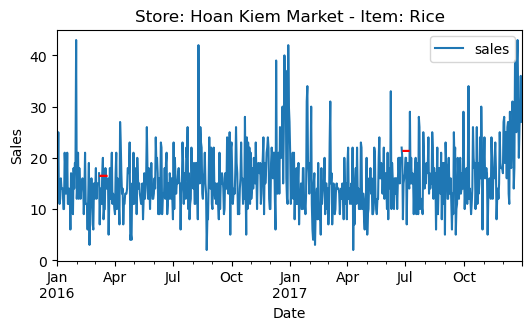

In [10]:
# Checking nan values and outliers in a plot
plot_sales(df_sales, store_id=1, item_id=1)

In [11]:
# Fill nan using mean values
df_sales_filled = fill_misisng_values(df_sales)

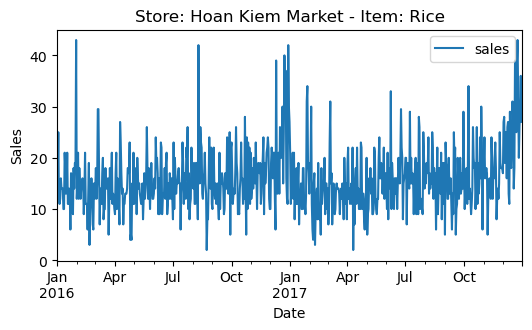

In [12]:
# Checking nan values and outliers in a plot
plot_sales(df_sales_filled, store_id=1, item_id=1)

In [13]:
# Check missing values
display(check_missing_values(df_sales_filled))

,counts,ratio (%)
date,0,0.0
province,0,0.0
store_id,0,0.0
store_name,0,0.0
category,0,0.0
item_id,0,0.0
item_name,0,0.0
sales,0,0.0


### Check and correct outliers

In [14]:
df_sales_filled

,date,province,store_id,store_name,category,item_id,item_name,sales
0,2016-01-01,Hanoi,1,Hoan Kiem Market,Staples,1,Rice,17.0
1,2016-01-01,Hanoi,1,Hoan Kiem Market,Staples,2,Noodles,10.0
2,2016-01-01,Hanoi,1,Hoan Kiem Market,Staples,3,Bread,6.0
3,2016-01-01,Hanoi,1,Hoan Kiem Market,Staples,4,Flour,8.0
4,2016-01-01,Hanoi,1,Hoan Kiem Market,Staples,5,Cooking Oil,8.0
...,...,...,...,...,...,...,...,...
201020,2017-12-31,Ho Chi Minh City,10,Binh Thanh Market,Baby & Health,31,Baby Wipes,41.0
201021,2017-12-31,Ho Chi Minh City,10,Binh Thanh Market,Baby & Health,32,Pain Relievers,20.0
201022,2017-12-31,Ho Chi Minh City,10,Binh Thanh Market,Baby & Health,33,Vitamins,19.0
201023,2017-12-31,Ho Chi Minh City,10,Binh Thanh Market,Baby & Health,34,Cold & Flu Medicine,5.0


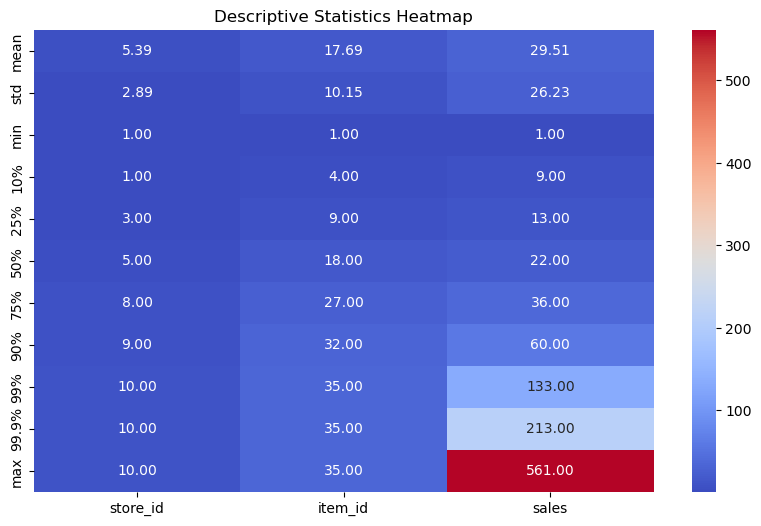

In [15]:
# Using heat map to visualize outliers
summary = (
    df_sales_filled[["store_id", "item_id", "sales"]]
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:]
)

plt.figure(figsize=(10, 6))
sns.heatmap(summary, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Descriptive Statistics Heatmap")
plt.show()

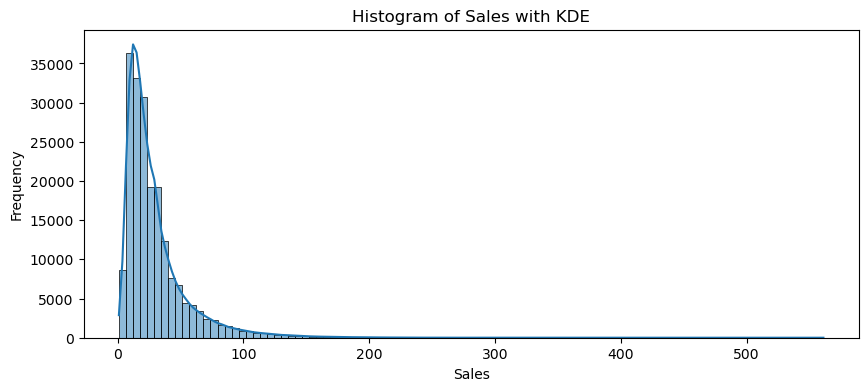

In [16]:
# plot the histogram
plt.figure(figsize=(10, 4))
sns.histplot(df_sales_filled["sales"], bins=100, kde=True)
plt.title("Histogram of Sales with KDE")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

In [17]:
# Correct outliers
df_sales_corrected = correct_outliers(df=df_sales_filled)

In [18]:
# Check if outliers were corrected properly
summary = (
    df_sales_corrected[["store_id", "item_id", "sales"]]
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:]
)
display(summary)

,store_id,item_id,sales
mean,5.392727,17.694545,27.164819
std,2.889226,10.152023,19.601623
min,1.000000,1.000000,1.000000
10%,1.000000,4.000000,9.000000
25%,3.000000,9.000000,13.000000
50%,5.000000,18.000000,22.000000
75%,8.000000,27.000000,34.000000
90%,9.000000,32.000000,54.000000
99%,10.000000,35.000000,96.000000
99.9%,10.000000,35.000000,107.000000


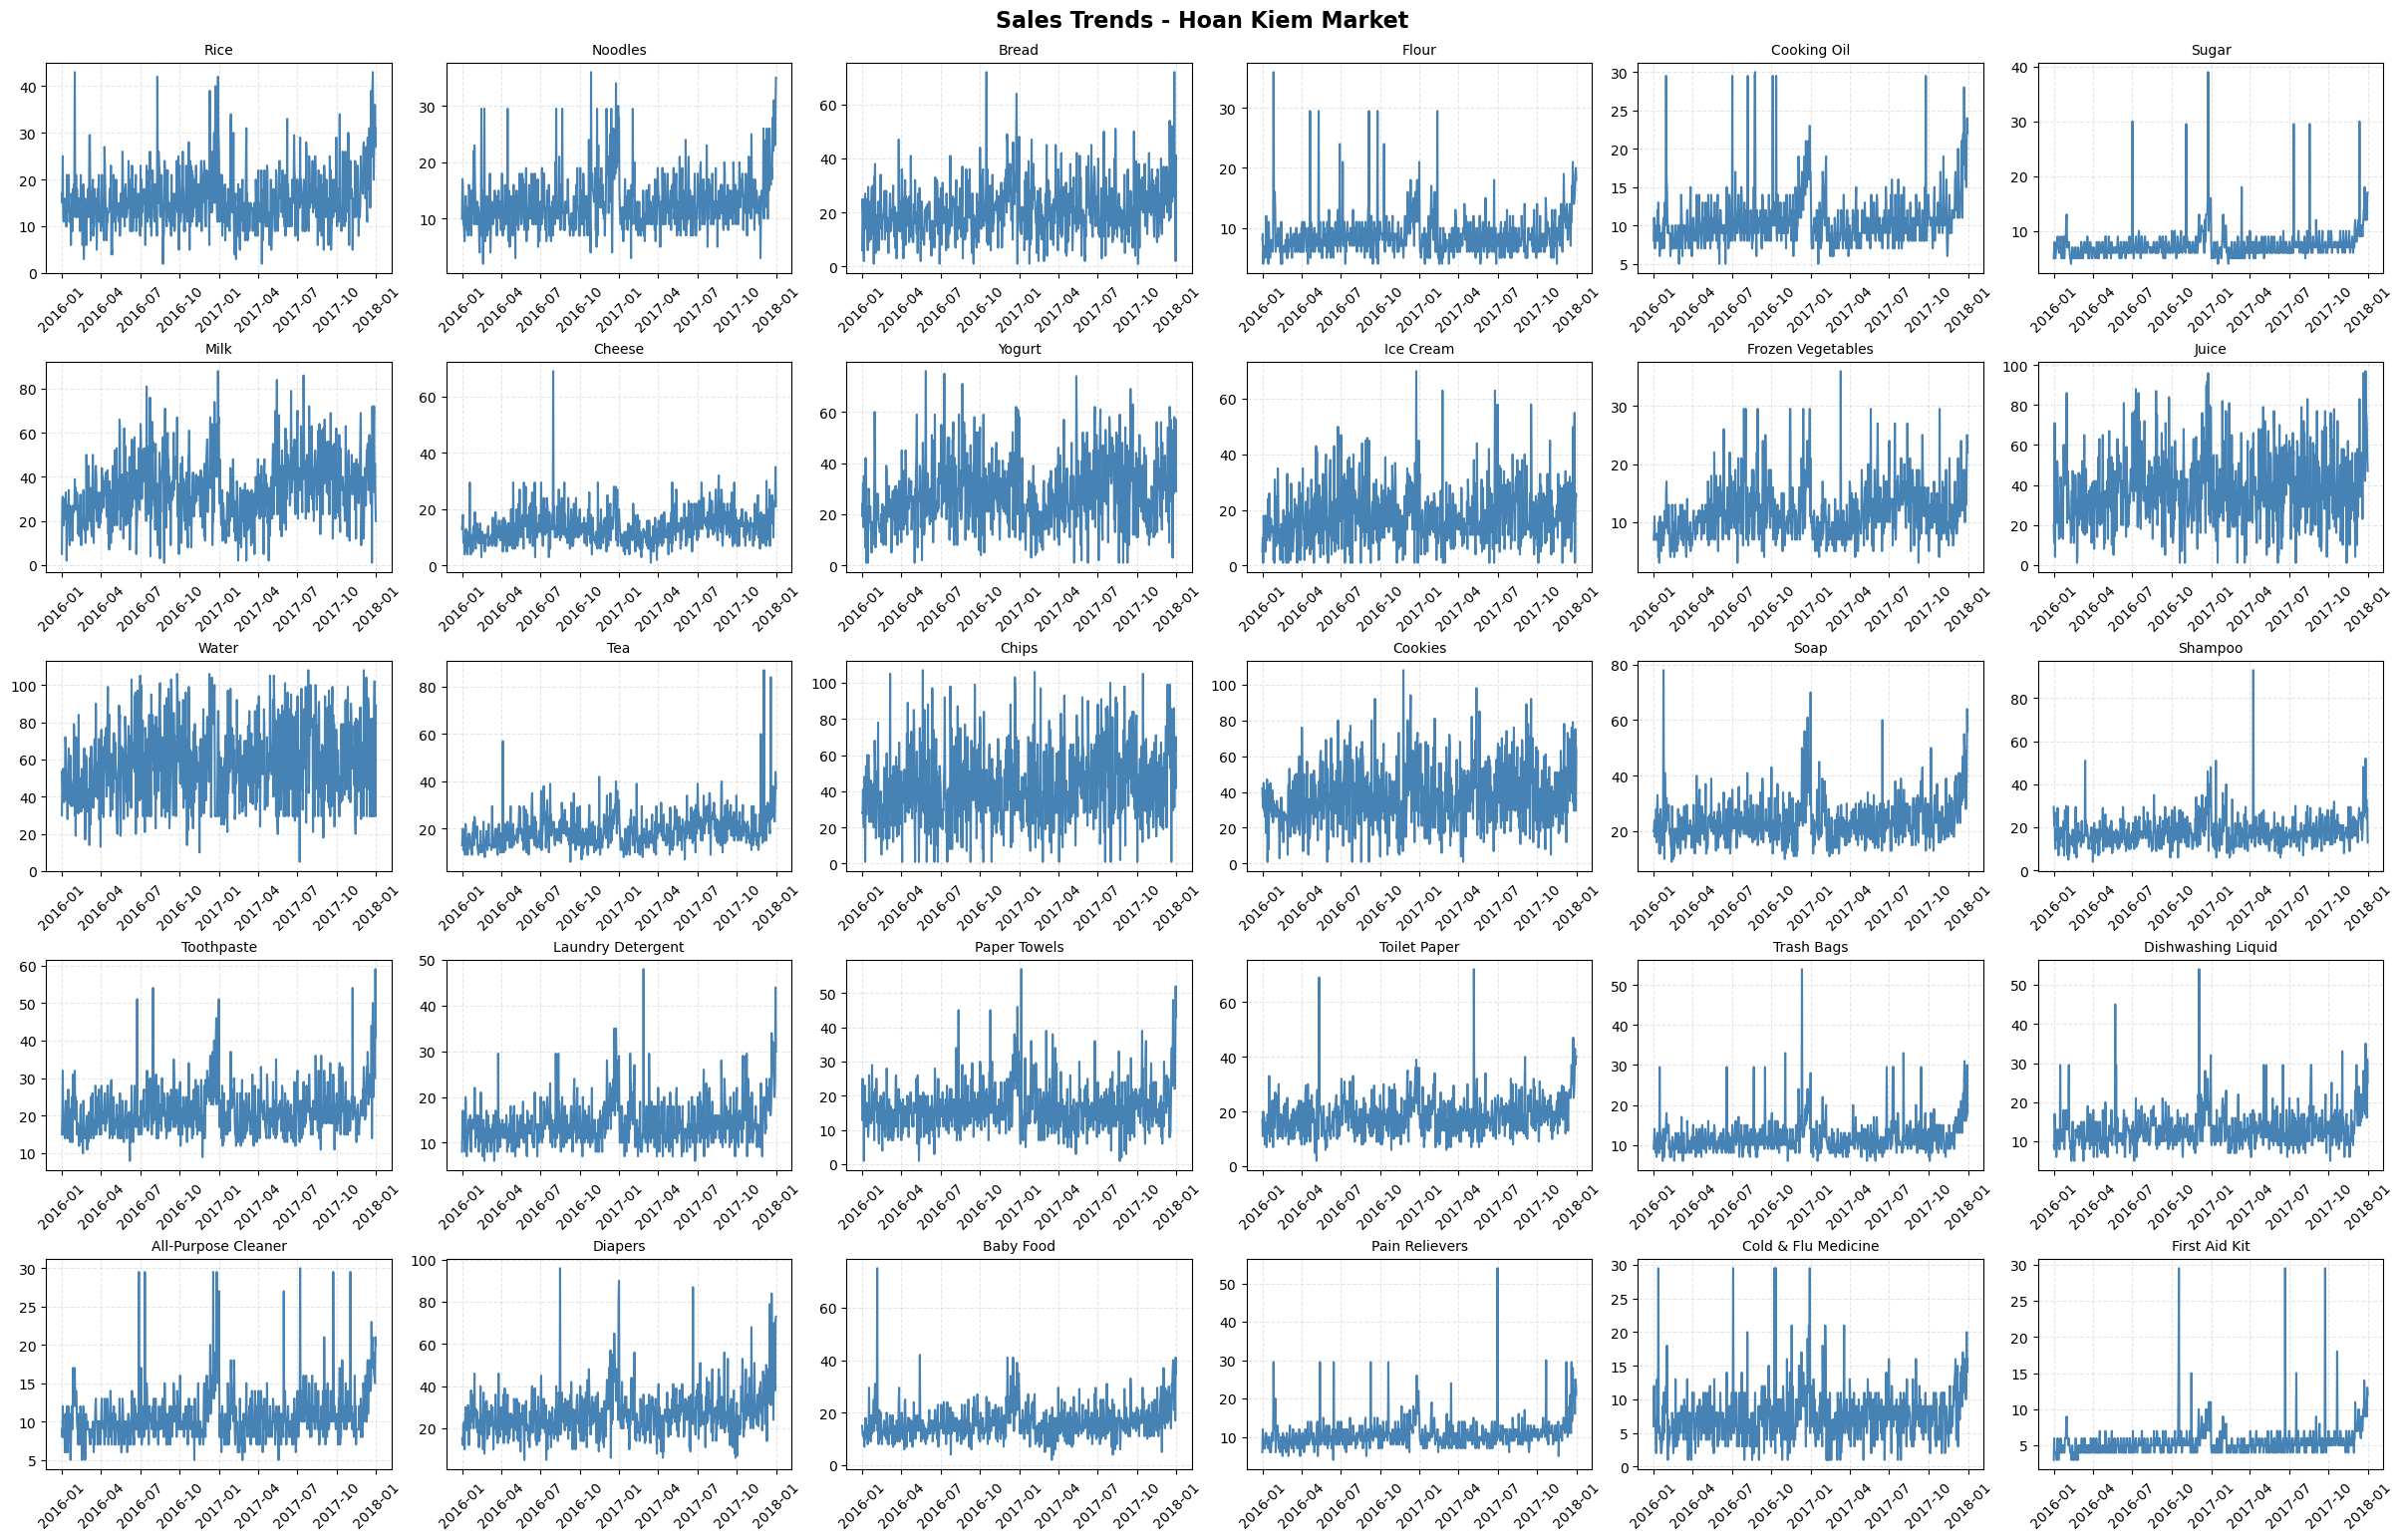

In [19]:
# Get targeted store
store_id = 1
df_sample_store = get_sample_stores(df_sales_corrected, store_id=store_id)
store_name = df_sample_store["store_name"].iloc[-1]

# Grid layout
nrows, ncols = 5, 6
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 4, nrows * 3), constrained_layout=True
)
axes = axes.flatten()

lst_items = df_sample_store["item_id"].unique().tolist()

for idx, (item_id, ax) in enumerate(zip(lst_items, axes)):
    df2plot = df_sample_store.query("item_id == @item_id")
    item_name = df2plot["item_name"].iloc[-1]

    ax.plot(df2plot["date"], df2plot["sales"], color="steelblue", linewidth=1.5)
    ax.set_title(f"{item_name}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, linestyle="--", alpha=0.3)

# Hide unused subplots
for ax in axes[len(lst_items) :]:
    ax.axis("off")

# Main title
fig.suptitle(f"Sales Trends - {store_name}", fontsize=16, fontweight="bold", y=1.02)
plt.show()

In [20]:
check_missing_values(df_sales_corrected)

,counts,ratio (%)
date,0,0.0
province,0,0.0
store_id,0,0.0
store_name,0,0.0
category,0,0.0
item_id,0,0.0
item_name,0,0.0
sales,0,0.0


### Weather data

In [21]:
# Convert city in weather to province to match with sales data
# Since the cities and provinces have the same names in our dataset
df_weather = df_weather.rename(columns={"city": "province"})

# Create a mapping between date and province to weather attributes
weather_mapping = df_weather.set_index(["date", "province"])
weather_mapping

temperature  humidity  season
date       province                                       
2016-01-01 Hanoi                    13.4      87.8  winter
           Ho Chi Minh City         27.7      69.1     dry
2016-01-02 Hanoi                    15.2      75.2  winter
           Ho Chi Minh City         26.6      69.9     dry
2016-01-03 Hanoi                    19.2      86.0  winter
...                                  ...       ...     ...
2017-12-29 Ho Chi Minh City         27.3      77.6     dry
2017-12-30 Hanoi                    20.9      80.8  winter
           Ho Chi Minh City         28.0      69.1     dry
2017-12-31 Hanoi                    15.3      70.7  winter
           Ho Chi Minh City         25.9      67.7     dry

[1462 rows x 3 columns]

## Save preprocessed data

In [22]:
# Saving sales data
sales_data_path = os.path.join(DATA_DIR, "sales_data_preprocessed.csv")
print(f"Saving sales data to :{sales_data_path}")
df_sales_corrected.to_csv(sales_data_path, index=False)

# Saving weather data
weather_data_path = os.path.join(DATA_DIR, "weather_preprocessed.csv")
print(f"Saving weather data to :{weather_data_path}")
df_weather.to_csv(weather_data_path, index=False)

Saving sales data to :../data/sales_data_preprocessed.csv
Saving weather data to :../data/weather_preprocessed.csv
